In [1]:
import umap
import numpy as np
import umap.plot
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import pandas as pd
%matplotlib inline

min_max_scaler = MinMaxScaler()

In [3]:
df_test= pd.read_csv('/media/jadhavlab/Data2/Volcanoes/test.csv',index_col=0)
df_test = df_test.T.drop_duplicates().T

df_train= pd.read_csv('/media/jadhavlab/Data2/Volcanoes/train.csv',index_col=0)
df_train = df_train.T.drop_duplicates().T

In [4]:
df_train['desig']=0
df_test['desig']=1

In [5]:
df_combo=df_test.append(df_train)

In [6]:
df_combo.fillna(df_combo.median(), inplace=True)
#df_combo[df_combo.filter(regex='kurtosis|skew|hyperskew|hj3').columns]=min_max_scaler.fit_transform(
#    df_combo[df_combo.filter(regex='kurtosis|skew|hyperskew|hj3').columns])

In [7]:
df_combo.fillna(df_combo.median(), inplace=True)
df_combo=pd.DataFrame(data=min_max_scaler.fit_transform(df_combo),columns=df_combo.columns, index=df_combo.index)
df_combo.fillna(df_combo.median(), inplace=True)
df_combo.drop(columns='sensor_1_nan%',inplace=True)

In [8]:
df_train=df_combo.loc[df_combo.desig==0]
df_test=df_combo.loc[df_combo.desig==1]
df_train=df_train.drop(columns='desig')
df_test=df_test.drop(columns='desig')

In [9]:
df_labels=pd.read_csv('/media/jadhavlab/Data2/Volcanoes/predict-volcanic-eruptions-ingv-oe/train.csv',index_col=0)

In [10]:
dfjoin=df_train.join(df_labels)
color=dfjoin.time_to_eruption.values

In [19]:
transformer = umap.UMAP(n_components=3).fit(dfjoin.drop(columns='time_to_eruption').values)

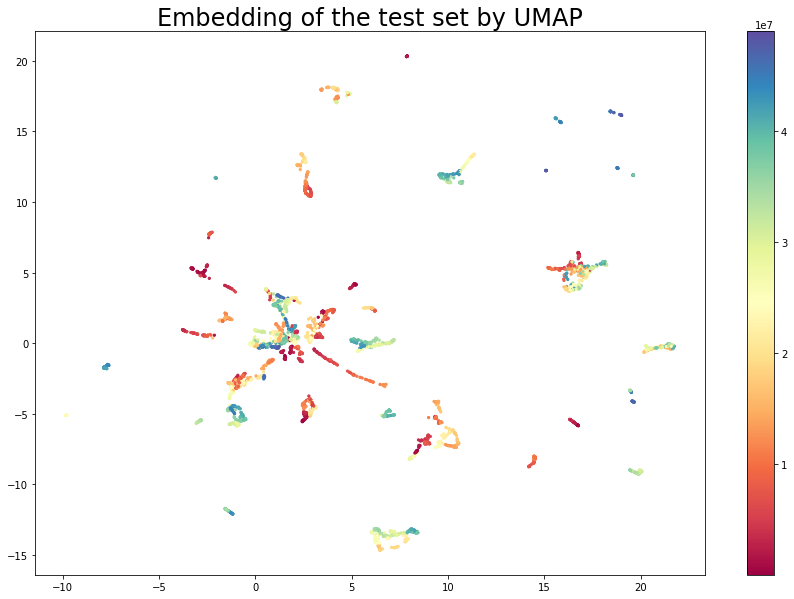

In [17]:
plt.figure(figsize=(15,10))
plt.scatter(transformer.embedding_[:, 0], transformer.embedding_[:, 1], s= 5,c=color, cmap='Spectral')
plt.title('Embedding of the test set by UMAP', fontsize=24);
plt.colorbar()

<IPython.core.display.Javascript object>


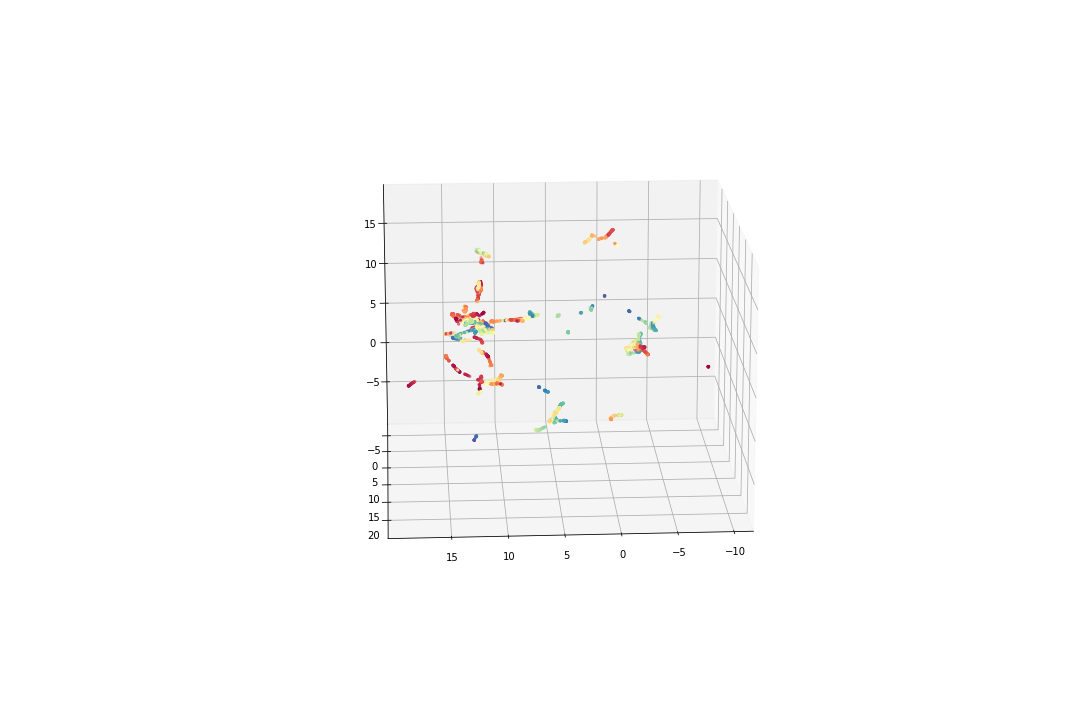

In [20]:
%matplotlib notebook
fig= plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(transformer.embedding_[:, 0],
           transformer.embedding_[:, 1],
           transformer.embedding_[:, 2],s= 5, c=color, cmap='Spectral')
#plt.scatter(transformer.embedding_[:, 0], transformer.embedding_[:, 1], s= 5, c=dfjoin[i], cmap='Spectral')
#plt.title('Embedding of the training set by UMAP', fontsize=24);
#plt.colorbar()

In [ ]:
for i in dfjoin.columns:
    fig= plt.figure(figsize=(15,10))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(transformer.embedding_[:, 0],
#           transformer.embedding_[:, 1],
#           transformer.embedding_[:, 2],s= 5, c=color, cmap='Spectral')
    plt.scatter(transformer.embedding_[:, 0], transformer.embedding_[:, 1], s= 5, c=dfjoin[i], cmap='Spectral')
    plt.title('Embedding of the training set by UMAP', fontsize=24);
    #plt.colorbar()
    plt.savefig('testvolcano/'+i+'.png')
    plt.close()
#for angle in range(0, 360):
#    ax.view_init(30, ang7le)
#    plt.draw()
#    plt.pause(.001)


In [12]:
test_embedding = transformer.transform(df_test.values)

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 5)
plt.title('Embedding of the test set by UMAP', fontsize=24);
plt.colorbar()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
regr = GradientBoostingRegressor()
regr.fit(transformer.embedding_, color)
preds = regr.predict(test_embedding)
preds
plt.scatter(np.arange(preds.shape[0]),preds)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
regr = GradientBoostingRegressor()
regr.fit(dfjoin.drop(columns='time_to_eruption').values, color)
preds = regr.predict(df_test)
preds
plt.scatter(np.arange(preds.shape[0]),preds)

In [ ]:
dfsolution= pd.DataFrame(preds,index=df_test.index,columns=['time_to_eruption'])
dfsolution.index.name = 'segment_id'
dfsolution.to_csv('/media/jadhavlab/Data2/Volcanoes/solution.csv')

In [13]:
# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental    import enable_hist_gradient_boosting
from sklearn.ensemble        import HistGradientBoostingRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics         import mean_absolute_error

In [14]:
rkf = RepeatedKFold(n_splits=10,n_repeats=100)

predictions_array = []
CV_score_array    = []

#X=dfjoin.drop(columns='time_to_eruption').values
#y=color
#X_test=df_test

X=transformer.embedding_.astype(np.float64)
y=color
X_test=test_embedding.astype(np.float64)

for train_index, test_index in rkf.split(X):
    
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    
    regressor =  HistGradientBoostingRegressor()
    regressor.fit(X_train, y_train)
    
    predictions_array.append(regressor.predict(X_test))
    CV_score_array.append(mean_absolute_error(y_valid,regressor.predict(X_valid)))    

predictions = np.mean(predictions_array,axis=0)

    
print("The average CV mean absolute error is %d" % np.mean(CV_score_array,axis=0))    
#The average CV mean absolute error is 5861174:7684251 actual
#The average CV mean absolute error is 6228752:7771900 actual
#The average CV mean absolute error is 4540989:8000103 actual
#The average CV mean absolute error is 4370589:7546802 actual
#The average CV mean absolute error is 4614134:7695555 actual
#The average CV mean absolute error is 5099712:8046228 actual
#The average CV mean absolute error is 2226571:6147949 actual
#The average CV mean absolute error is 2318437:6203907 actual
#The average CV mean absolute error is 2313337:6057523 actual
#The average CV mean absolute error is 2293994:6048142
#The average CV mean absolute error is 2283362
#The average CV mean absolute error is 2476071
#The average CV mean absolute error is 2230055:6195803
#The average CV mean absolute error is 2233983:5956165
#The average CV mean absolute error is 2880630:
#The average CV mean absolute error is 1793969:6376518
#The average CV mean absolute error is 1729016



The average CV mean absolute error is 1729016


In [15]:
dfsolution= pd.DataFrame(predictions,index=df_test.index,columns=['time_to_eruption'])
dfsolution.index.name = 'segment_id'
dfsolution.to_csv('/media/jadhavlab/Data2/Volcanoes/solution.csv')